# Deep Learning for Robotics Assignment 1 - Behavioral Cloning

This assignment will give you a tutorial on behavioral cloning, a very important tool for robot learning.  Behvioral cloning allows us to learn policies from datasets of previously collected demonstrations.  This is very powerful for a number of reasons.  First, these offline approaches do not require environment interactions (we do not need to query the environment for rewards as you need to do with Reinforcement Learning).  For robotics this is particularly helpful as environment interaction can be expensive or dangerous.  Even more importantly, offline approaches are necessary for robot learning as they allow for much greater scalability and portability (which is exactly what we are looking for in this era of deep learning).  Datasets of demonstrations can be shared across institutions and grown over time (think RT-X dataset).  These large scale datasets can help bring robotics closer to the successes of computer vision and NLP.  If you work in robotics you may realize that this is not exactly how things currently work, datasets are often not reused and it is very common to collect new data for every experiment.  This is exactly why we need better methods for behavioral cloning.  Learning effictive policies from diverse demonstration datasets is a very active area of research.

**Robomimic:** Robomimic is an open source platform for imitation learning algorithms and datasets.  The platform's foundational study paper investigates a variety of offline learning algorithms across a suite of demonstrated tasks (provided by real humans of differing skill levels).  The authors draw insights about algorithm design and dataset characterists from the results in this paper.  You will be using the robomimic codebase and datasets for this project.  At the end of the assignment you will conduct your own experiments and draw your own lessons about three key behavioral cloning algorithms.  You will read the robomimic paper (https://arxiv.org/abs/2108.03298) for the class on 2/14.

**Robosuite:** "Rososuite is a simulation framework powered by the MuJoCo physics engine for robot learning. It also offers a suite of benchmark environments for reproducible research."  This is the simulation environment upon which robomimic is build.
Here is the robosuite paper (https://arxiv.org/abs/2009.12293).

### Imports and Environment Setup

1. Download the DLM folder from canvas and upload it to your google drive.  It should contain DLM_A1.ipynb (this notebook), helper.py, and helper_models.py.

2. Click on this notebook in your google drive and open it with google colab.

3. Mount your google drive so that you can access the DLM folder

In [1]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4. Install necessary packages

In [2]:
%%capture
# install the necessary packages
!git clone https://github.com/ARISE-Initiative/robomimic
!pip install -e robomimic/
!git clone https://github.com/ARISE-Initiative/robosuite
!pip install mujoco
!pip install egl-probe


5. Add robomimic and robosuite to the system path.  Also make sure the path_to_dlm is set correctly, this should point to the location of the DLM folder in your google drive

In [3]:
import os
import sys

# change path to your DLM folder
path_to_dlm = '/content/drive/My Drive/DLM'

sys.path.append(path_to_dlm)
sys.path.append('./robomimic/')
sys.path.append('./robosuite/')

%load_ext autoreload
%autoreload 2

### Understanding the Datasets

Behavioral cloning is supervised learning.  We take in a dataset of (state, action) pairs, or (observation, action) pairs if we do not have access to the full state space.  The goal of behavioral cloning is to train a neural network that learns the mapping from states to actions.  Because we are directly learning the action distribution from the dataset, behavioral cloning is also called imitation learning.  A key feature of behavioral cloning is that we do not have access to reward labels.  This is good because labels are expensive, but bad because it is hard to contend with suboptimal data.  This is why many methods will assume access to expert demonstrations.  However, developing methods that can learn from suboptimal policies is an active area of research.  In later parts of this assignment you will experiment with how suboptimallity can affect training performance.

For this assignment you will be working with the robomimic codebase and datasets.  This section goes over how datasets are stored in robomimic.  We will start by downloading a demonstration dataset for the square task.  This requires putting a square peg through a square hole.

In [4]:
import robomimic.utils.file_utils as FileUtils
from robomimic import DATASET_REGISTRY

# set download folder
download_folder = os.path.join(path_to_dlm, 'datasets/square/ph')
os.makedirs(download_folder, exist_ok=True)

#download the dataset
task = "square"
dataset_type = "ph"
hdf5_type = "low_dim"
FileUtils.download_url(
    url=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=download_folder,
)

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /content/./robomimic/robomimic/scripts/setup_macros.py
)
y


low_dim_v141.hdf5: 53.0MB [00:11, 4.71MB/s]                            


In [5]:
# enforce that the dataset exists
dataset_path = os.path.join(download_folder, "low_dim_v141.hdf5")
assert os.path.exists(dataset_path)

Next we look at the contents of the dataset.  There is a lot more information stored in these datasets, but you just need to worry about the actions and the observations.  Actions are commonly stored as the delta joint positions of the robot, and the joint torques are calculated using inverse kinematics (this is just handled by a pre-written controller).  Observations include proprioception (joint/end-effector positions and velocites) as well as images or low dimensional states.

In [6]:
import h5py
# open file
f = h5py.File(dataset_path, "r")

# each demonstration is a group under "data".  each demonstration is named "demo_#" where # is a number, starting from 0
demos = list(f["data"].keys())
num_demos = len(demos)

print("hdf5 file {} has {} demonstrations".format(dataset_path, num_demos))

# look at first demonstration
demo_key = demos[0]
demo_grp = f["data/{}".format(demo_key)]

# actions is a num numpy array of shape (time, action dim)
actions = demo_grp["actions"][:]
print("shape of actions {}".format(actions.shape))

#Each observation is a dictionary that maps modalities to numpy arrays of shape (time, obs modality dim)
print("observations:")
for obs, obs_key in demo_grp["obs"].items():
    print("{} - shape {}".format(obs , obs_key.shape))

hdf5 file /content/drive/My Drive/DLM/datasets/square/ph/low_dim_v141.hdf5 has 200 demonstrations
shape of actions (127, 7)
observations:
object - shape (127, 14)
robot0_eef_pos - shape (127, 3)
robot0_eef_quat - shape (127, 4)
robot0_eef_vel_ang - shape (127, 3)
robot0_eef_vel_lin - shape (127, 3)
robot0_gripper_qpos - shape (127, 2)
robot0_gripper_qvel - shape (127, 2)
robot0_joint_pos - shape (127, 7)
robot0_joint_pos_cos - shape (127, 7)
robot0_joint_pos_sin - shape (127, 7)
robot0_joint_vel - shape (127, 7)


For pick and place tasks (which is what we are concerned with in this assignment), it is common to just use end-effector 6-DoF position and gripper state for the state of the robot.  Additionally, to speed up computation time we will be using low-dimensional states (not images) for the object observations.  You are welcome to use additional observations as you run your experiments.

Based on this information, we will be defining the input and output dimensions for the behavioral cloning networks.  Remember, the goal of behavioral cloning is to map observations to actions.

In [7]:
# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# add these together to get the input dim of 23
input_dim = end_effector_pos_dim + end_effector_quat_dim + gripper_qpos_dim + object_dim

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

For your experiments you may use a different dataset, in this case the object observations will be different.  Make sure to set the input dim correctly in this case.

Now we will specify these observations for robomimic

**You do not need to understand this, just run it every time**


In [8]:
# You do not need to understand this, just run it every time
import robomimic.utils.obs_utils as ObsUtils

obs_spec = dict(
    obs=dict(
            low_dim=[
                    "object",
                    "robot0_eef_pos",
                    "robot0_eef_quat",
                    "robot0_gripper_qpos",
                    ],
            rgb=[],
        ),
)
ObsUtils.initialize_obs_utils_with_obs_specs(obs_modality_specs=obs_spec)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'robot0_gripper_qpos', 'object', 'robot0_eef_pos']
using obs modality: rgb with keys: []


Finally, lets playback some of the demonstrations so you can visualize exactly what these demonstrations look like.  The rollouts and video generation are very slow...  Keep this in mind when working on this homework assignment.  There is not much code for you to implement, but **make sure you leave yourself plenty of time to run the rollouts!**

In [ ]:
import helper
import importlib
importlib.reload(helper)
from IPython.display import Video
import robomimic.utils.obs_utils as ObsUtils

# prepare to write playback trajectories to video
video_path = os.path.join(download_folder, "playback.mp4")

helper.playback_demos(video_path, dataset_path, num_rollouts = 2)

# view the trajectories!
Video(video_path, embed=True)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /content/./robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name NutAssemblySquare
Action size is 7
Playing back demo key: demo_0
Playing back demo key: demo_1


# Implementing the Algorithms

As mentioned before, behavioral cloning is just supervised learning.  So common deep learning networks and techniques can easily be applied to imitation learning.  While in some cases learning the action distribution can be difficult, the main challenge with behavioral cloning (and with many supervised learning problems) is dealing with distribution shifts.  If the conditions during evaluation are not exactly the same as conditions during data collection, networks can make inaccurate action predictions in these unseen states.  In sequential decision making scenarios (such as robotics), the challenges of out of distribution data are even more extreme.  This is because of compounding errors.  An inaccurate action prediction will throw you into an out of distribution state, and once you are out of distribution, subsequent inaccurate predictions take you even farther from the demonstration data.  In other supervised learning settings (such as classification for computer vision), an incorrect prediction is not going to make future predictions any less accurate.  So even in these simulation environments where the evaluation conditions are exactly the same as they were during data collection, you will notice that completing these tasks with a high success rate is not trivial.  Developing imitation learning methods that can better generalize to out of distribution scenarios is an important area of research.


You will be implementing three behavioral cloning algorithms in this section.  For each algorithms do the following:

**Instructions - Hit threshold for rollout success rate, plot training and validation loss curves, analyze**

## MLP (10 points)

First we will be implementing the most simple version of Behavioral Cloning - a Multi-Layer Perceptron that directly maps observations to actions.  For this part of the assignment, you will be filling in the MLP class.  

In [9]:
# Load in the data for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=dataset_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 376.39it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 27165/27165 [00:01<00:00, 17900.68it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 238.04it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 2989/2989 [00:00<00:00, 5824.79it/s] 
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 14])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


While filling in the class you will need to do the following:
* Initialize the network in the init function
* Implement the logic for training on a batch of data
* Implement the logic for prediction an action based on an observation


In [10]:
#Derrick Joyce

import torch
import torch.nn as nn
import torch.optim as optim
#torch summary

class DLMMLP(nn.Module):
  def __init__(
      self,
      input_dim,
      hidden_dims,
      output_dim,
      obs_keys
    ):
    """
    Args:
    - input_dim (int): dimension of input obs
    - hidden_dims (list of int): dimensions of hidden layers
    - output_dim (int): dimension of output action
    - obs_keys (list of str): keys of obs modalities
    """
    super(DLMMLP, self).__init__()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ###############################################
    # Define the model architecture here          #
    # Create network layers.                      #
    # Create network optimizer.                   #
    # Adam optimizer with lr = 0.0001 should work #
    ###############################################
    # 1) Define mlp and set current dim as input dim
    self.mlp = nn.ModuleList()
    current_dim = input_dim

    # 2) Append linear layers, incrementing the current_dim
    for h_dim in hidden_dims:
      self.mlp.append(nn.Linear(current_dim,h_dim))
      self.mlp.append(nn.Tanh())
      current_dim = h_dim

    # 3) Add last linear layer connecting to output dimension
    self.mlp.append(nn.Linear(current_dim,output_dim))

    # # 4) Put into sequential container?
    # self.model = nn.Module(self.mlp)

    # 5) Adam Optimizer
    self.optim = optim.Adam(params=self.parameters(), lr = 0.0001)
    ###############################################
    # End of code                                 #
    ###############################################

    self.obs_keys = obs_keys
    self.to(self.device)
    # This is just for saving the model, don't use this parameter
    self.epoch = 0

  # Need forward function for module
  def forward(self, observations):
    for layer in self.mlp:
      observations = layer(observations)
    return observations

  def train_on_batch(self, batch, validate):
    """
    Args:
    - batch (dict): batch of data batch['obs'].shape = (B, T, Obs_dim)
                    and batch['actions'].shape = (B, T, Action_dim)
    - validate (bool): whether batch is for validation

    Returns:
    - loss_val (float): value of loss
    """
    loss_val = None
    #############################################
    # Define the training loop here             #
    # Compute action prediction                 #
    # Use MSE to calculate loss                 #
    # If validate == True, dont backprop.       #
    #############################################
    # observations and actions are GT
    observations = batch['obs']
    actions = batch['actions']

    pred = self(observations)

    #calc loss between predictions and GT actions
    self.mse = nn.MSELoss()
    loss = self.mse(pred,actions)

    # backprop if validate = false
    if not validate:
      self.optim.zero_grad()
      loss.backward()
      self.optim.step()
    loss_val = loss.item()

    ######################################
    # End of code                        #
    ######################################
    return loss_val

  def get_action(self, obs):
    """
    Args:
    - obs (torch.Tensor): (B, 1, Obs_dim)
    Returns:
    - action (torch.Tensor): (B, 1, Action_dim)
    """
    # put model in eval mode
    self.eval()
    action = None
    ######################################
    # Compute action from observation    #
    # Pass obs through the network       #
    # use torch.no_grad()                #
    ######################################
    with torch.no_grad():
      action = self(obs)
    ######################################
    # End of code                        #
    ######################################
    return action

  def reset(self):
    return

  def save(self, path):
    torch.save(self.state_dict(), path)

  def load(self, path, map_location=None):
    #get epoch from end of path
    self.epoch = int(path.split("_")[-1].split(".")[0])
    self.load_state_dict(torch.load(path,map_location=map_location))

  def set_eval(self):
    self.eval()


Create the model and train.  Do not worry about having a complicated network architecture, even a simple MLP will be able to model the observation-action distribution fairly well.  But hopefully you can see there are a lot of parameters you could change during your experiments at the end of this assignment.

In [ ]:
# input_dim = 23 (observation dims) and output_dim = 7 (actions= dim) are calculated in the first section
# remember, input_dim = end_effector_pos_dim + end_effector_quat_dim + gripper_qpos_dim + object_dim

# you can tune these, but if implemented correctly the MLP does not need much tuning

hidden_dims = [1024, 1024]
model = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, obs_keys = obs_keys)


Now it is time to train the model, you should be able to achieve the target success rate after ~250 training epochs (5 min).

**Target Success Rate: 40%**

In [ ]:

from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/mlp")
if not os.path.exists(save_path):
  os.makedirs(save_path)

num_epochs = 301


# train_losses and valid losses are lists of (loss, epoch) tupples
model.train_losses, model.valid_losses = train(model, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path)


In [ ]:
# Load saved model if you have checkpoints from previous training runs

model.load(os.path.join(save_path, "epoch_150.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))


It will take quite a while to run the rollout loop, so start by visualizing one or two rollouts.  Do the robots actions look reasonable after training for 250 epochs?  Or is it bouncing around wildly?  If it is doing random things, your model is not implemented correctly.  

Remember you have visualizations of the original demonstrations earlier in this notebook if you want to remember the behavior we are trying to imitate.  Also, every part of this process is very stochastic.  Even if you get 0/2 success rate this doesn't necessarily mean your implementation is incorrect.

In [ ]:
# Visualize a few trajectories for debugging
from helper import rollout
import imageio

# create a video writer
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

# you can change this while debugging
num_rollouts = 2

success_rate = rollout(model,
                      dataset_path,
                      horizon = 400,
                      video_writer = video_writer,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

video_writer.close()

Created environment with name NutAssemblySquare
Action size is 7
Success rate over 2 rollouts: 0.0


In [ ]:
from IPython.display import Video
Video(video_path, embed=True)

Once you are confident in your model, take the time to run the full 50 rollouts.  If your success rate is low, you can try training for longer (or sometime even loading an earlier checkpoint helps as well).  The upper range of success rates should be ~60%, but 40% success rate is full credit.

(10 min runtime)

**Do not delete the final output of this cell!  We need to see the final success rate to score you correctly.**

In [ ]:
from helper import rollout
import imageio

# Do not change num_rollouts
num_rollouts = 50

# video write is off to speed up rollouts slightly
success_rate = rollout(model,
                      dataset_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

'''
Load cpu on cpu and gpu on gpu (cpu )
Tanh activation
model 300 = 28% success
model 250 = 30% success
model 200 = 12% success
model 150 = 42% success
model 100 = 12% success
'''

Created environment with name NutAssemblySquare
Action size is 7
Success rate over 50 rollouts: 0.4


'\nTanh activation\nmodel 300 = 28% success\nmodel 250 = 30% success\nmodel 200 = 12% success\nmodel 150 = 42% success\nmodel 100 = 12% success\n'

## TODO: Plot Training and Validation Loss
Additionally, indicate the checkpoint epoch you used to generate the success rate above.  Write 2/3 sentences reflecting on your takeaways from this process.  Do the training and validation loss curves make sense?  Would it have been easy to pick out the best checkpoint without running the rollouts?

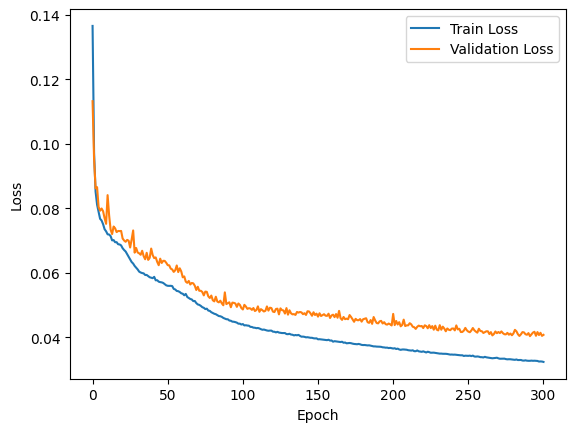

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# convert lists to numpy arrays
train_losses = np.array(model.train_losses)
valid_losses = np.array(model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


**Your Analysis Here -**

**I utilized checkpoint epoch 150 because it gave the highest success rate for this task. Looking at the loss curves, they do not readily show that epoch 150 would've given the best result, therefore showing that lower loss doesn't necessarily translate to higher performance**

### RNN (10 points)

For the MLP, the state that we are passing into the model is actionally quite limited.  The model can only see the current position of the end effect and the object.  How might we be able to deal with this partial observability?  One possible solution is adding velocity, acceleration, jerk, etc. to the state.  Another solution is passing in a number of previous observations at once.  While both of these methods could work (and may be worth trying during your experiments), with increasingly complex inputs the model becomes computationally expensive, requires more demonstrations, and runs the risk of focusing on spurrious correlations in the data.  

In this section, we will tackle the problem of partial observability by training a network that retains a memory of its past experiences, a Recurrent Neural Network (RNN).  The hidden state of the RNN contains information about what happened in previous timesteps.  The hope is that these learned parameters allow the model to infer some unobserved but relavent aspects of the data, such as velocity or motion patterns.  


We will now reload the dataset with a sequence length of 10.  You can change this sequence length in your experiments, but for now please use 10.

In [11]:
from helper import load_data_for_training
# For experiments, it is probably best to just alter these parameters
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 10
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=dataset_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 204.81it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 27165/27165 [00:03<00:00, 7100.29it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 139.37it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 2989/2989 [00:00<00:00, 7428.56it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 10, 14])
robot0_eef_pos shape: torch.Size([100, 10, 3])
robot0_eef_quat shape: torch.Size([100, 10, 4])
robot0_gripper_qpos shape: torch.Size([100, 10, 2])
action shape: torch.Size([100, 10, 7])


Below you will implement the RNN, here are some guidlines:
* Use nn.LSTM and a fully connected output layer
* Inilitalize hidden state to zeros
* When generating actions, keep track of the hidden state and re-initialize after self.hidden_state_horizon action steps

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import robomimic.utils.tensor_utils as TensorUtils

class DLM_RNN(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        num_layers,
        output_dim,
        obs_keys,
        rnn_horizon
    ):
        super(DLM_RNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_keys = obs_keys
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.hidden_state = None
        self.hidden_state_horizon = rnn_horizon
        self.hidden_state_counter = 0
        ############################################
        # Define the model architecture here       #
        # 1. Initialize LSTM                       #
        # 2. Initialize fully connect output layer #
        # 3. Initializer optimizer (same as MLP)   #
        ############################################
        # 1) LSTM + output layer
        self.lstm = nn.LSTM(input_dim, self.hidden_size, self.num_layers,batch_first=True)
        self.out_layer = nn.Linear(self.hidden_size, output_dim)

        # 2) Adam Optimizer
        self.optim = optim.Adam(params=self.parameters(), lr=0.0001)

        # 3) Initialize self_hidden_state
        #self.hidden_state = self.initialize_hidden_state(batch_size)

        ##########################################
        # End of code                            #
        ##########################################
        self.to(self.device)
        # This is just for saving the model, don't use this parameter
        self.epoch = 0

    def train_on_batch(self, batch, validate):
      """
      Args:
      - batch (dict): batch of data batch['obs'].shape = (B, T, Obs_dim)
                    and batch['actions'].shape = (B, T, Action_dim)
      - validate (bool): whether batch is for validation

      Returns:
      - loss_val (float): value of loss
      """
      loss_val = None
      ######################################################
      # Define the training loop here                      #
      # 1. Pass obs (and hidden state) through LSTM        #
      # 2. Predict actions using fully connected layer     #
      # 3. Compute MSELoss (for all actions)               #
      # 4. Backprop if not validate                        #
      ######################################################
      obs = batch['obs']
      actions = batch['actions']

      # 1) Initialize hidden state
      self.hidden_state = self.initialize_hidden_state(obs.size(0))

      # 2) Forward pass through lstm and output layer
      output, self.hidden_state = self.lstm(obs, self.hidden_state)
      pred_action = self.out_layer(output)

      #calc loss between predictions and GT actions
      self.mse = nn.MSELoss()
      loss = self.mse(pred_action,actions)

      # backprop if validate = false
      if not validate:
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
      loss_val = loss.item()
      ######################################
      # End of code                        #
      ######################################
      return loss_val

    def initialize_hidden_state(self, batch_size):
      """
      Args:
      - batch_size (int): size of batch
      Returns:
      - (h_0, c_0) : initial hidden state and cell state for LSTM
      """
      h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
      c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
      return h_0, c_0

    def get_action(self, obs):
      # This function is used in evaluation, not training
      """
      Args:
      - obs (dict): dictionary of observations of shape (B, 1, Obs_dim)
      Returns:
      - action (torch.Tensor): action of shape (B, 1, Action_dim)
      """

      ##############################################################
      # Implement logic for action prediction                      #
      # 1. Hidden state should be re-initialized after             #
      #    every self.hidden_state_horizon steps                   #
      # 2. Pass obs through LSTM (along with previus hidden state) #
      # 3. Then use fully connected layer to predict action        #
      # Note: use torch.no_grad()                                  #
      ##############################################################
      # put model in eval mode
      self.eval()
      action = None

      # 1) Reinitialize hidden state after every self.hidden_state_horizon steps
      self.hidden_state_counter += 1

      if self.hidden_state_counter % self.hidden_state_horizon == 0:
          self.hidden_state = self.initialize_hidden_state(1)
      with torch.no_grad(): #for testing
        # 2) LSTM Forward Pass
        output, self.hidden_state = self.lstm(obs, self.hidden_state)
        #self.hidden_state = (h,c)

        # 3) Fully connected layer to predict action
        pred_action = self.out_layer(output)

        ##############################################################
        # End of code                                                #
        ##############################################################
        return pred_action

    def reset(self):
      # Reset hidden state and hidden state counter
      self.hidden_state = None
      self.hidden_state_counter = 0
      return

    def save(self, path):
      torch.save(self.state_dict(), path)

    def load(self, path, map_location=None):
        # get epoch from end of path
        self.epoch = int(path.split("_")[-1].split(".")[0])
        self.load_state_dict(torch.load(path, map_location=map_location))


    def set_eval(self):
      self.eval()


Create the model and train.  Most of the challenge with this model is correctly handeling the hidden state.  

In [ ]:
# input_dim = 23 (observation dims) and output_dim = 7 (actions= dim) are calculated in the first section
# remember, input_dim = end_effector_pos_dim + end_effector_quat_dim + gripper_qpos_dim + object_dim

# you can modify these parameters if you want, but tuning shouldn't be necessary
hidden_dim = 400
num_layers = 2
# make sure rnn_horizon is same as dataloader sequence length
rnn_horizon = 10
model = DLM_RNN(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim, obs_keys = obs_keys, rnn_horizon = rnn_horizon)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/rnn")
if not os.path.exists(save_path):
  os.makedirs(save_path)

Now it is time to train the model, you should be able to achieve the target success rate after ~500 training epochs (20 min).  When debugging feel free to train for less epochs.

**Target Success Rate: 70%**

In [ ]:
num_epochs = 500

model.train_losses, model.valid_losses = train(
                                  model,
                                  train_loader,
                                  valid_loader,
                                  num_epochs=num_epochs,
                                  save_path=save_path
                                )


Epoch: 0 Train Loss: 0.16887076555148645 Valid Loss: 0.13190208251277605
0 0
Epoch: 10 Train Loss: 0.05628627214087721 Valid Loss: 0.06189353714386622
Epoch: 20 Train Loss: 0.04748536379295675 Valid Loss: 0.05637195259332657
Epoch: 30 Train Loss: 0.043870016151820034 Valid Loss: 0.05431951247155666
Epoch: 40 Train Loss: 0.04090657289249494 Valid Loss: 0.05107941602667173
Epoch: 50 Train Loss: 0.03843427969909766 Valid Loss: 0.0472225159406662
50 50
Epoch: 60 Train Loss: 0.036898543147425 Valid Loss: 0.04592286025484403
Epoch: 70 Train Loss: 0.03530097229625372 Valid Loss: 0.04390392452478409
Epoch: 80 Train Loss: 0.033920120632768995 Valid Loss: 0.04260023062427839
Epoch: 90 Train Loss: 0.03252796465120114 Valid Loss: 0.04133480327824752
Epoch: 100 Train Loss: 0.03122232048361398 Valid Loss: 0.04068196409692367
100 100
Epoch: 110 Train Loss: 0.02996227507452097 Valid Loss: 0.04180420401195685
Epoch: 120 Train Loss: 0.02861770675928496 Valid Loss: 0.04060082559784253
Epoch: 130 Train Lo

In [ ]:
# Load saved model if you have checkpoints from previous training runs
model.load(os.path.join(save_path, "epoch_450.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_450.pth"))

As mentioned before, it will take quite a while to run the rollout loop, so start by visualizing one or two rollouts.  Does the robots actions look reasonable?  Or is it bouncing around wildly?  Remember you have visualizations of the original demonstrations earlier in this notebook if you want to remember the behavior we are trying to imitate.

In [ ]:
from helper import rollout
import imageio

# create a video writer
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

# Feel free to change while debugging
num_rollouts = 2
success_rate = rollout(model,
                      dataset_path,
                      horizon = 400,
                      video_writer = video_writer,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

video_writer.close()

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /content/./robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name NutAssemblySquare
Action size is 7
Success rate over 2 rollouts: 1.0


In [ ]:
from IPython.display import Video
Video(video_path, embed=True)

Once you are confident that your model is reasonable, then you can take the time to run the full 50 rollouts.

(10 min)

**Do not delete the final output of this cell! We need to see your success rate to score you correctly**

In [ ]:
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(model,
                      dataset_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

'''
Load cpu on cpu and gpu on gpu (cpu )

model 450 = 74% success

'''

Created environment with name NutAssemblySquare
Action size is 7
Success rate over 50 rollouts: 0.74


'\nLoad cpu on cpu and gpu on gpu (cpu )\n\nmodel 450 = 74% success\n\n'

## TODO: Plot Training and Validation Loss
Additionally, indicate the checkpoint epoch you used to generate the success rate above.  Write 2/3 sentences reflecting on your takeaways from this process.  If you have time, try loading some of the earlier saved checkpoints and plotting the success rate curve as well (it is okay if you don't have time for this).



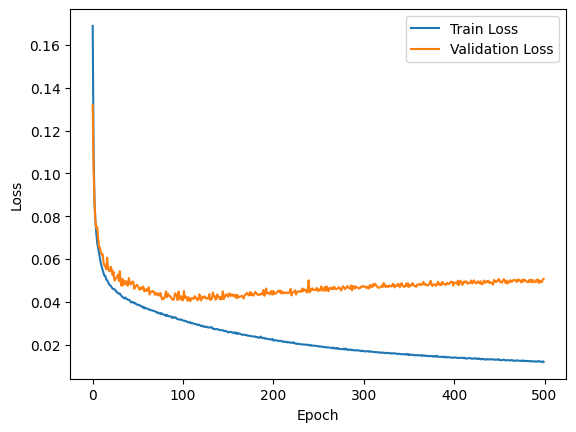

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# convert lists to numpy arrays
train_losses = np.array(model.train_losses)
valid_losses = np.array(model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

**I chose checkpoint epoch 450 because it gave a high enough success rate. Similar to the MLP, the validation loss shows that an earlier epoch (epoch 100 perhaps) would've been the best model, however this is also incorrect**

**Your Analysis Here -**

### Diffusion Policy (10 points) **Extra Credit**

Now you will be implementing action prediction with a Diffusion Model.  Diffusion Models are an extremely popular class of generative models, especially because of their ability to represent multimodal distributions.  For this model your noise will be the shape of the actions that you want to predict and your conditioning information will be the observations.  If you need a refresher on Diffusion Models there are a lot of good resources online, but here are the papers that you are expected to understand to complete this part of the assignment.  You will have a hard time completing this assignment if you have never read these papers:

https://arxiv.org/pdf/2006.11239.pdf (Original Diffusion Model Paper)

https://arxiv.org/pdf/2303.04137.pdf (Diffusion Policy, the paper this implementation is based on)

In [ ]:
%%capture
!pip install diffusers

In [ ]:
from helper import load_data_for_training
# For experiments, it is probably best to just alter these parameters
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 16
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=dataset_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size,
    frame_stack = 1,
)

You will be implementing a very basic version of diffusion policy.  We will use a fixed beta schedule, a constant learning rate, no observation normalization, and delta actions instead of absolute.  For this reason your success rate may not be amazing, but this should give you a sense of how diffusion models can be used for action generation.  Feel free to add any of these components during your experiments if you want to try and get better success rates.  The guidelines for implementing the diffusion model policy are as follows:
* Use DDPMScheduler to add noise to actions during training
* Train noise_pred_net on these noised actions
* Use noise_pred_net to predict the amount of noise to remove at each timestep during inference
* Use DDPMScheduler to remove noise during inference
* You should be using 0 mean, 1 var gaussian noise (torch.randn)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import robomimic.utils.tensor_utils as TensorUtils
from copy import deepcopy

# do not import any additional diffusion model packages for this part of the assignment
# you are free to implement any packages you want for the experiments at the end of the assignment
from diffusers import DDPMScheduler
from helperModels import ConditionalUnet1D
from diffusers.training_utils import EMAModel



class DLM_Diffusion(nn.Module):
  def __init__(
      self,
      output_dim,
      input_dim,
      denoising_steps,
      obs_horizon,
      prediction_horizon,
      action_horizon,
    ):

    super(DLM_Diffusion, self).__init__()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.denoising_steps = denoising_steps
    self.output_dim = output_dim
    self.obs_horizon = obs_horizon
    self.prediction_horizon = prediction_horizon
    self.action_horizon = action_horizon
    self.input_dim = input_dim

    ######################################
    # Initialize the noise pred net      #
    # Change the input and cond dims     #
    ######################################
    # Input_dim is action dim
    # global con dim is flattened obs dim
    self.noise_pred_net = ConditionalUnet1D(
      input_dim=None,
      global_cond_dim=None,
    )
    ######################################
    # End of code                        #
    ######################################


    self.scheduler = DDPMScheduler(
        num_train_timesteps=self.denoising_steps,
        # the choise of beta schedule has big impact on performance
        # we found squared cosine works the best
        beta_schedule='squaredcos_cap_v2',
        # clip output to [-1,1] to improve stability
        clip_sample=True,
        # our network predicts noise (instead of denoised action)
        prediction_type='epsilon'
    )

    self.noise_pred_net.to(self.device)
    self.optimizer = optim.Adam(self.noise_pred_net.parameters(), lr=1e-4)
    self.ema = EMAModel(parameters=self.noise_pred_net.parameters(),power=0.75)
    self.ema.to(self.device)
    # This is just for saving the model, don't use this parameter
    self.epoch = 0



  def train_on_batch(self, batch, validate):
    """
    Args:
    - batch (dict): batch of data batch['obs'].shape = (B, T, Obs_dim) and batch['actions'].shape = (B, T, Action_dim)
    - validate (bool): whether batch is for validation
    Returns:
    - loss_val (float): value of loss
    """
    loss_val = None
    ######################################
    # Define the training loop here      #
    ######################################
    # make sure to flatten obs (B, T, D) -> (B, --)

    ######################################
    # End of code                        #
    ######################################
    return loss_val

  def get_action(self, obs):
    """
    Args:
    - obs (dict): dictionary of observations of shape (B, prediction_horizon, Obs_dim)
    Returns:
    - actions (np.ndarray): action of shape (B, action_horizon, Action_dim)
    """
    # obs are (B, T, D) - make sure to flatten obs
    # also, remember obs_horizon is not the same as prediction_horizon
    original_params = deepcopy(self.noise_pred_net.state_dict())
    self.ema.copy_to(self.noise_pred_net.parameters())
    self.noise_pred_net.eval()
    actions = None

    ######################################################
    # Generate an action sample from the diffusion model #
    ######################################################

    ####################################################################################
    #                                 END OF YOUR CODE                                 #
    ####################################################################################

    # restore original params
    self.noise_pred_net.load_state_dict(original_params)

    return actions

  def reset(self):
    return

  def save(self, path):
    torch.save(self.state_dict(), path)
    # save the ema model, put ema before the .pth
    torch.save(self.ema.state_dict(), path.replace(".pth", "ema.pth"))

  def load(self, path):
    #get epoch from end of path
    self.epoch = int(path.split("_")[-1].split(".")[0])
    self.load_state_dict(torch.load(path))
    self.ema.load_state_dict(torch.load(path.replace(".pth", "ema.pth")))

  def set_eval(self):
    self.eval()

Create the mode and train.  It is really important that you understand the diffusion model training and inference process, if you are having troubles please review the basics of diffusion models.

In [ ]:
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/diffusion")
if not os.path.exists(save_path):
  os.makedirs(save_path)

In [ ]:
# input_dim = 23 (observation dims) and output_dim = 7 (actions= dim) are calculated in the first section
# remember, input_dim = end_effector_pos_dim + end_effector_quat_dim + gripper_qpos_dim + object_dim

denoising_steps = 100
prediction_horizon = 16
action_horizon = 8
obs_horizon = 2

model = DLM_Diffusion(
    output_dim = output_dim,
    input_dim = input_dim,
    denoising_steps=denoising_steps,
    prediction_horizon=prediction_horizon,
    action_horizon=action_horizon,
    obs_horizon = obs_horizon
    )

In [ ]:
# Load saved model if you have checkpoints from previous training runs
# model.load(os.path.join(save_path, "model_50.pth"))

Now it is time to train the model, you should be able to achieve the target success rate after ~50 training epochs. (1 hr)

**Target Success Rate: 50%**

In [ ]:
num_epochs = 51
training_losses, validation_losses = train(model, train_loader, valid_loader, num_epochs=num_epochs, save_path = save_path)

This will take a really really long time to run (even longer than the last ones).  Please keep this in mind when doing your experiments.  We do not recommend doing experiments that will increase you inference time, maybe forcus on experiments that lower inference time.  First lets debug by visualizing a few rollouts.

In [ ]:
from helper import rollout
import imageio

# create a video writer
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

num_rollouts = 2
success_rate = rollout(model,
                      dataset_path,
                      horizon = 400,
                      video_writer = video_writer,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts,
                      obs_len = 2)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

video_writer.close()

In [ ]:
from IPython.display import Video
Video(video_path, embed=True)

Once you are confident that your model is reasonable, then you can take the time to run the full 50 rollouts.

(35 min)

**Do not delete the final output of this cell! We need to see your success rate to score you correctly**

In [ ]:
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(model,
                      dataset_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts,
                      obs_len = 2)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

## TODO: Plot Training and Validation Loss
Additionally, indicate the checkpoint epoch you used to generate the success rate above.  Write 2/3 sentences reflecting on your takeaways from this process.  How was the training different from the other models?  Why can you use such an early checkpoint?

**Your Analysis Here -**

# Experiments (30 points)

Okay now it is time to do some experiments with the models you implemented.  There are 4 different variables that we want you to investigate.  For each section you need to come up with a hypothesis, run an experiment to test that hypothesis, and then analyze whether or not your hypothesis was proved or disproved.  These do not need to be novel discoveries, we just want you to see how common dataset characteristics are impacted by different aspects of these models.  For each section below the points breakdown is as follows:

* (2pt) **Hypothesis** - For each dataset characteristic, formulate a hypothesis that explores the interaction between this characteristic and a specific variable or parameter in one of your implemented models. Your hypothesis should reflect how changes in the model parameter might influence the performance or behavior of the model with respect to the given dataset characteristic.
* (4pt) **Experiment** -  Describe the experiment you ran and include at least one figure.
* (4pt) **Analysis** - Explain whether or not your hypothesis was proved or disproved.  What would be an interesting next experiment after seeing these results?


**To get full credit**, you must experiment with the parameters off all implemented models at least once (except the diffusion model as this is extra credit).  For example, you can't just modify the parameters of the MLP for all experiments.  Failure to do so will results in -5 points.

This is the bulk of the homework assignment! So have a good time with it, make pretty graphs, and hopefully discover something interesting.

## **Task Difficulty (10 PT)**
Lift (easy) vs. Square (medium) vs. Tool Hang (Hard)

Example Hypothesis: If I increase the depth of the MLP, I will see increased performance on harder tasks.

The robomimic demonstration datasets contain a number of different tasks with varying levels of difficulty.  Below we provide download links to three such tasks.  You can load them into the data loaders from previous sections as you perform your experiments.  

In [13]:
# Download demonstration dataset
import robomimic.utils.file_utils as FileUtils

# the dataset registry can be found at robomimic/__init__.py
from robomimic import DATASET_REGISTRY

# set download folder for EASY task
lift_folder = os.path.join(path_to_dlm, 'datasets/lift/ph')
os.makedirs(lift_folder, exist_ok=True)

#download the dataset
task = "lift"
dataset_type = "ph"
hdf5_type = "low_dim"
FileUtils.download_url(
    url=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=lift_folder,
)

# enforce that the dataset exists
lift_path = os.path.join(lift_folder, "low_dim_v141.hdf5")
assert os.path.exists(lift_path)

# set download folder for MEDIUM task
square_folder = os.path.join(path_to_dlm, 'datasets/square/ph')
os.makedirs(square_folder, exist_ok=True)

#download the dataset
task = "square"
dataset_type = "ph"
hdf5_type = "low_dim"
FileUtils.download_url(
    url=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=square_folder,
)

# enforce that the dataset exists
square_path = os.path.join(square_folder, "low_dim_v141.hdf5")
assert os.path.exists(square_path)

# set download folder for HARD task
tool_hang_folder = os.path.join(path_to_dlm, 'datasets/tool_hang/ph')
os.makedirs(tool_hang_folder, exist_ok=True)

#download the dataset
task = "tool_hang"
dataset_type = "ph"
hdf5_type = "low_dim"
FileUtils.download_url(
    url=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=tool_hang_folder,
)

# enforce that the dataset exists
tool_hang_path = os.path.join(tool_hang_folder, "low_dim_v141.hdf5")
assert os.path.exists(tool_hang_path)

y


low_dim_v141.hdf5: 21.7MB [00:04, 5.39MB/s]                            


y


low_dim_v141.hdf5: 53.0MB [00:08, 6.21MB/s]                            


y


low_dim_v141.hdf5: 205MB [00:45, 4.48MB/s]                           


### TODO:

**Enter your hypotheses here:**
If I increase (double) the number of nodes in the hidden_dim (width), performance will increase on harder tasks

**You can add however many code blocks here, but leave the most essential ones upon submission to prove your work.**


**Enter your experiment here:**

1) Train baseline lift MLP model and a modified lift MLP Model (hidden_dims = [2048,2048])

2) Repeat for square and TH

3) Compare Success Rates

TD: LIFT

In [ ]:
# 1) Load in the lift data (easy) for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=lift_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# Lift has input of 19
input_dim = 19

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 593.63it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 8640/8640 [00:00<00:00, 19134.17it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 381.76it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 1026/1026 [00:00<00:00, 19724.78it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 10])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


In [ ]:
# 1) Train baseline lift model and then increase the width of the hidden dims for modified
hidden_dims = [1024,1024]
lift_model = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, obs_keys = obs_keys)

hidden_dims_mod = [2048, 2048]
lift_model_mod = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims_mod, output_dim=output_dim, obs_keys = obs_keys)

In [ ]:
# 1) Train Baseline Lift model
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/tdmlp_lift")
if not os.path.exists(save_path):
  os.makedirs(save_path)

num_epochs = 251

# train_losses and valid losses are lists of (loss, epoch) tupples
#lift_model.train_losses, lift_model.valid_losses = train(lift_model, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path)

# Train modified lift model
# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path_mod = os.path.join(path_to_dlm, "trainings/tdmlp_lift_mod")
if not os.path.exists(save_path_mod):
  os.makedirs(save_path_mod)

# train_losses and valid losses are lists of (loss, epoch) tupples
#lift_model_mod.train_losses, lift_model_mod.valid_losses = train(lift_model_mod, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path_mod)



In [ ]:
# 1) Alternatively, load saved model from previous training runs

lift_model.load(os.path.join(save_path, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))


In [ ]:
# 1) Alternatively, load saved models from previous training runs

lift_model_mod.load(os.path.join(save_path_mod, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))

In [ ]:
# 1) Generate Success Rollouts for ORIGINAL
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(lift_model,
                      lift_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Lift Model Success rate over {} rollouts: {}".format(num_rollouts, success_rate))



[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /content/./robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name Lift
Action size is 7
Lift Model Success rate over 50 rollouts: 1.0


In [ ]:
# 1) Generate Success Rollouts for MOD
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(lift_model_mod,
                      lift_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Lift Model Mod Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

'''
Load cpu on cpu and gpu on gpu (cpu )

model 450 = 74% success

'''

Created environment with name Lift
Action size is 7
Lift Model Mod Success rate over 50 rollouts: 1.0


'\nLoad cpu on cpu and gpu on gpu (cpu )\n\nmodel 450 = 74% success\n\n'

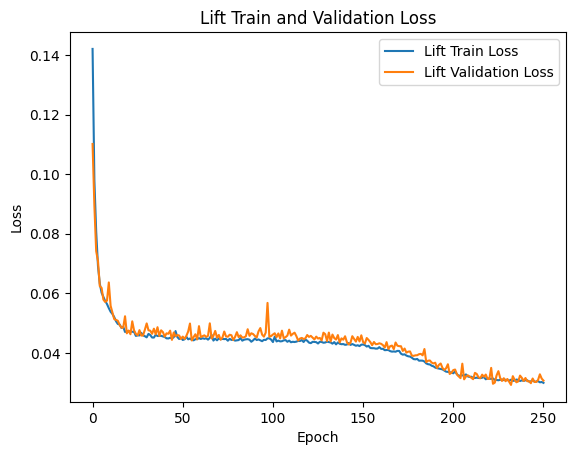

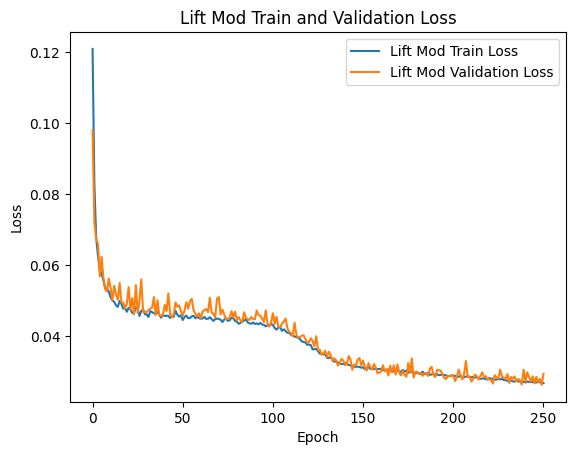

In [ ]:
# 1) Plot Losses
import numpy as np
import matplotlib.pyplot as plt

# convert lists to numpy arrays
train_losses = np.array(lift_model.train_losses)
valid_losses = np.array(lift_model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Lift Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Lift Validation Loss")

plt.title("Lift Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

train_losses = np.array(lift_model_mod.train_losses)
valid_losses = np.array(lift_model_mod.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Lift Mod Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Lift Mod Validation Loss")

plt.title("Lift Mod Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


TD: SQUARE

In [ ]:
# 2) Load in the square data (medium) for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=square_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# Square has input of 23
input_dim = 23

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 419.27it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 27165/27165 [00:01<00:00, 26753.61it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 337.49it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 2989/2989 [00:00<00:00, 30165.34it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 14])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


In [ ]:
# 2) Train baseline square model and then increase the width of the hidden dims for modified
hidden_dims = [1024,1024]
square_model = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, obs_keys = obs_keys)

hidden_dims_mod = [2048, 2048]
square_model_mod = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims_mod, output_dim=output_dim, obs_keys = obs_keys)

In [ ]:
# 2) Train Baseline Square model
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/tdmlp_square")
if not os.path.exists(save_path):
  os.makedirs(save_path)

num_epochs = 251

# train_losses and valid losses are lists of (loss, epoch) tupples
#square_model.train_losses, square_model.valid_losses = train(square_model, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path)

# Train modified square model
# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path_mod = os.path.join(path_to_dlm, "trainings/tdmlp_square_mod")
if not os.path.exists(save_path_mod):
  os.makedirs(save_path_mod)

# train_losses and valid losses are lists of (loss, epoch) tupples
#square_model_mod.train_losses, square_model_mod.valid_losses = train(square_model_mod, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path_mod)



In [ ]:
# 2) Alternatively, load saved model from previous training runs
# Used model 150 because that was the best checkpoint in previous training

square_model.load(os.path.join(save_path, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))


In [ ]:
# 2) Alternatively, load saved model from previous training runs

square_model_mod.load(os.path.join(save_path_mod, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))

In [ ]:
# 2) Generate Success Rollouts ORIGINAL
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(square_model,
                      square_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Square Model Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

Created environment with name NutAssemblySquare
Action size is 7
Square Model Success rate over 50 rollouts: 0.2


In [ ]:
# 2) Generate Success Rollouts MOD
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(square_model_mod,
                      square_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Square Model Mod Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

'''
Load cpu on cpu and gpu on gpu (cpu )

'''

Created environment with name NutAssemblySquare
Action size is 7
Square Model Mod Success rate over 50 rollouts: 0.3


'\nLoad cpu on cpu and gpu on gpu (cpu )\n\nmodel 450 = 74% success\n\n'

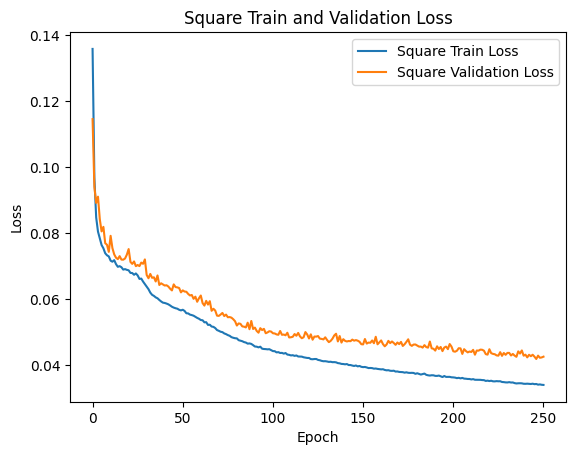

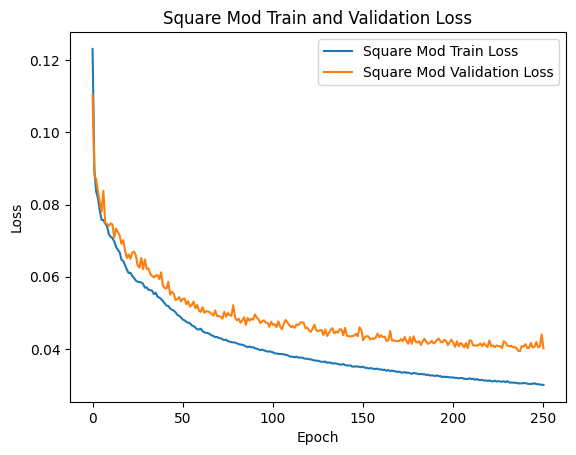

In [ ]:
# 2) Plot Losses
import numpy as np
import matplotlib.pyplot as plt

# convert lists to numpy arrays
train_losses = np.array(square_model.train_losses)
valid_losses = np.array(square_model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Square Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Square Validation Loss")

plt.title("Square Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

train_losses = np.array(square_model_mod.train_losses)
valid_losses = np.array(square_model_mod.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Square Mod Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Square Mod Validation Loss")

plt.title("Square Mod Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


TD: TOOL HANG

In [ ]:
# 3) Load in the tool_hang data (hard) for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=tool_hang_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# Tool hang has input of 53
input_dim = 53

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 233.26it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 86336/86336 [00:06<00:00, 12744.49it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 234.02it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 9626/9626 [00:00<00:00, 20575.67it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 44])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


In [ ]:
# 3) Train baseline tool hang model and then increase the width of the hidden dims for modified
hidden_dims = [1024,1024]
tool_hang_model = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, obs_keys = obs_keys)

hidden_dims_mod = [2048, 2048]
tool_hang_model_mod = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims_mod, output_dim=output_dim, obs_keys = obs_keys)

In [ ]:
# 3) Train Baseline tool hang model
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/tdmlp_TH")
if not os.path.exists(save_path):
  os.makedirs(save_path)

num_epochs = 501

# train_losses and valid losses are lists of (loss, epoch) tupples
#tool_hang_model.train_losses, tool_hang_model.valid_losses = train(tool_hang_model, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path)


In [ ]:
# 3) Train Baseline tool hang model
from helper import train
num_epochs = 501

# Train modified square model
# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path_mod = os.path.join(path_to_dlm, "trainings/tdmlp_TH_mod")
if not os.path.exists(save_path_mod):
  os.makedirs(save_path_mod)

# train_losses and valid losses are lists of (loss, epoch) tupples
#tool_hang_model_mod.train_losses, tool_hang_model_mod.valid_losses = train(tool_hang_model_mod, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path_mod)



In [ ]:
# 3) Alternatively, load saved model from previous training runs

tool_hang_model.load(os.path.join(save_path, "epoch_500.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))


In [ ]:
# 3) Alternatively, load saved model from previous training runs

tool_hang_model_mod.load(os.path.join(save_path_mod, "epoch_500.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))

In [ ]:
# TRAIN TH LONGER
# 3) Generate Success Rollouts for ORIGINAL
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(tool_hang_model,
                      tool_hang_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Tool Hang Model Success rate over {} rollouts: {}".format(num_rollouts, success_rate))


Created environment with name ToolHang
Action size is 7
Tool Hang Model Success rate over 50 rollouts: 0.0


In [ ]:
# 3) Generate Success Rollouts for both MOD
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(tool_hang_model_mod,
                      tool_hang_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Tool Hang Model Mod Success rate over {} rollouts: {}".format(num_rollouts, success_rate))


Created environment with name ToolHang
Action size is 7
Tool Hang Model Mod Success rate over 50 rollouts: 0.0


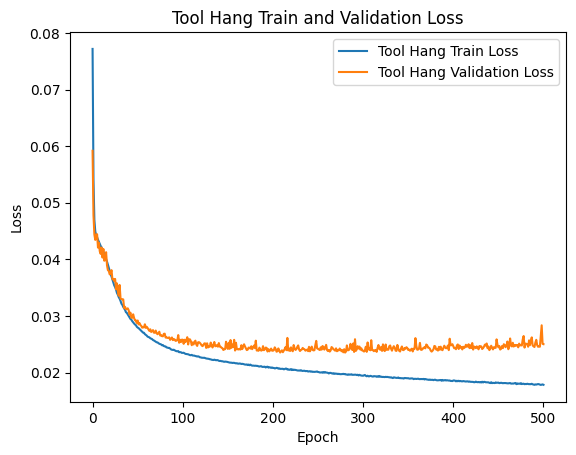

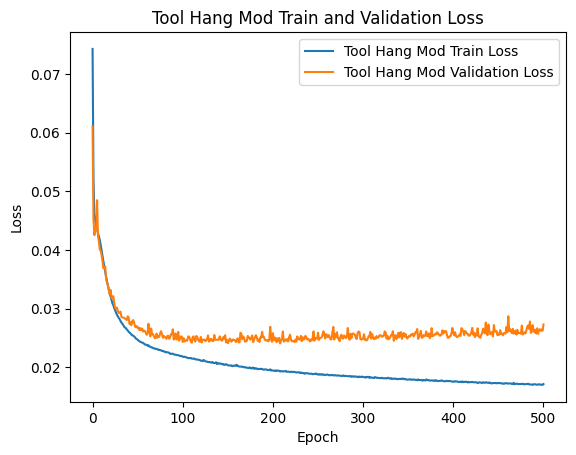

In [ ]:
# 3) Plot Losses
import numpy as np
import matplotlib.pyplot as plt

# convert lists to numpy arrays
train_losses = np.array(tool_hang_model.train_losses)
valid_losses = np.array(tool_hang_model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Tool Hang Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Tool Hang Validation Loss")

plt.title("Tool Hang Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

train_losses = np.array(tool_hang_model_mod.train_losses)
valid_losses = np.array(tool_hang_model_mod.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Tool Hang Mod Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Tool Hang Mod Validation Loss")

plt.title("Tool Hang Mod Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


**Include figures, brief explanation of the figures. You may use more than one cell**

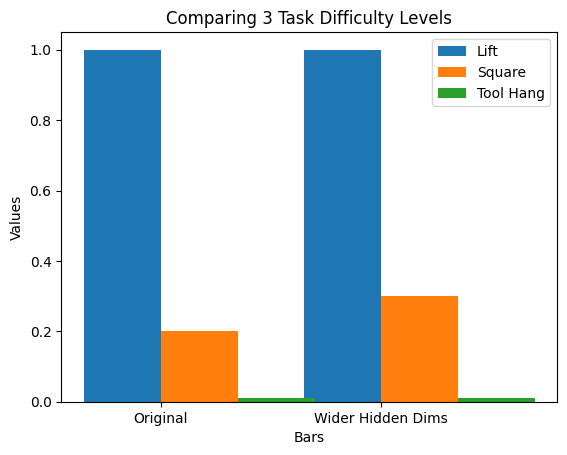

In [ ]:
# Comparison of all three
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Lift', 'Square', 'Tool Hang']
bar_labels = ['Original', 'Wider Hidden Dims']

# Sample values for each bar in each category
values = np.array([[1.0, 1.0],  # Lift success rates
                   [0.2, 0.3],   # Square success rates
                   [0.01, 0.01]])  # Tool Hang success rates ()

# Set up the figure and axis
fig, ax = plt.subplots()

# Define bar width
bar_width = 0.35

# Create bars for each category
for i, category in enumerate(categories):
    x = np.arange(len(bar_labels)) + i * bar_width
    ax.bar(x, values[i], width=bar_width, label=category)

# Set labels and title
ax.set_xlabel('Bars')
ax.set_ylabel('Values')
ax.set_title('Comparing 3 Task Difficulty Levels')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(bar_labels)) + bar_width / 2)
ax.set_xticklabels(bar_labels)

# Add legend
ax.legend()

# Show the plot
plt.show()


**Enter your analysis here** (be concrete about how each result validates or invalidates your hypothesis and why):

**Analysis: As shown in the final combined graph, my hypothesis of widening the hidden layers to improve performance on harder tasks was disproven. I increased the number of nodes from 1024 to 2048, and this only impacted the success of the square task. Because lifting is an easy task, the success rate was 100% even with the original MLP. The success rate of the square increased 10%. However, the tool hang task had a perpetual success rate of 0% regardless of the hidden layer width.**

## **Dataset Quality (10 PT)**


Example Hypothesis:  If I lower the diffusion model denoising steps, I will get lower success rate on suboptimal data.

In addition to different tasks, the robomimic datasets also have demonstrations from different quality demonstrators.  These were captures by either only proficient humans (ph) or a mixtured of human demonstrators (mh), including some suboptimal demonstrations.  Below we will download the mh dataset for the square task (ph dataset already downloaded in previous sections), but feel free to change this code and experiment with mh/ph on any task.

In [13]:
import robomimic.utils.file_utils as FileUtils
from robomimic import DATASET_REGISTRY

# set download folder for MEDIUM task
square_mh_folder = os.path.join(path_to_dlm, 'datasets/square/mh')
os.makedirs(square_mh_folder, exist_ok=True)

#download the dataset
task = "square"
dataset_type = "mh"
hdf5_type = "low_dim"
FileUtils.download_url(
    url=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=square_mh_folder,
)

# enforce that the dataset exists
square_mh_path = os.path.join(square_mh_folder, "low_dim_v141.hdf5")
assert os.path.exists(square_mh_path)

y


low_dim_v141.hdf5: 128MB [00:24, 5.15MB/s]                           


### TODO:

**Enter your hypotheses here:**
If I increase the number of nodes in the hidden_dim (width) of the square_mh mlp model, performance will increase and/or equate to the performance of the square_ph mlp model. Also comparing to baseline square_mh model for completeness

**You can add however many code blocks here, but leave the most essential ones upon submission to prove your work.**


**Enter your experiment here:**

1) Train baseline square_ph MLP model

2) Train square_mh MLP model

3) Train modified square_mh MLP model (hidden_dims = [2048,2048])

4) Compare Success Rates

In [ ]:
# 1) Load in the square data (medium) for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=square_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# Square has input of 23
input_dim = 23

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:01<00:00, 128.98it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 27165/27165 [00:05<00:00, 4948.77it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 214.02it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 2989/2989 [00:00<00:00, 5468.61it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 14])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


In [ ]:
# 1) Train baseline square model and then increase the width of the hidden dims for modified
hidden_dims = [1024,1024]
square_ph_model = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, obs_keys = obs_keys)

In [ ]:
# 1) Train Baseline Square model
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/tdmlp_square")
if not os.path.exists(save_path):
  os.makedirs(save_path)

num_epochs = 251

# train_losses and valid losses are lists of (loss, epoch) tupples
#square_model.train_losses, square_model.valid_losses = train(square_model, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path)


In [ ]:
# 1) Load in the square ph model (already previously trained)

square_ph_model.load(os.path.join(save_path, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))


In [ ]:
# 1) Load in the square mh data (medium) for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=square_mh_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# Square has input of 23
input_dim = 23

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

SequenceDataset: loading dataset into memory...
100%|██████████| 270/270 [00:00<00:00, 281.07it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 72707/72707 [00:04<00:00, 15118.98it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 30/30 [00:00<00:00, 268.62it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 8024/8024 [00:00<00:00, 17511.70it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 14])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


In [ ]:
hidden_dims = [1024, 1024]
square_mh_model = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, obs_keys = obs_keys)

hidden_dims_mod = [2048, 2048]
square_mh_model_mod = DLMMLP(input_dim=input_dim, hidden_dims=hidden_dims_mod, output_dim=output_dim, obs_keys = obs_keys)

In [ ]:
# Train square mh model
# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path_mod1 = os.path.join(path_to_dlm, "trainings/dqmlp_square_mh")
if not os.path.exists(save_path_mod1):
  os.makedirs(save_path_mod1)

# train_losses and valid losses are lists of (loss, epoch) tupples
#square_mh_model.train_losses, square_mh_model.valid_losses = train(square_mh_model, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path_mod1)


# Train modified square mh model
# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path_mod2 = os.path.join(path_to_dlm, "trainings/dqmlp_square_mh_mod")
if not os.path.exists(save_path_mod2):
  os.makedirs(save_path_mod2)

# train_losses and valid losses are lists of (loss, epoch) tupples
#square_mh_model_mod.train_losses, square_mh_model_mod.valid_losses = train(square_mh_model_mod, train_loader, valid_loader, num_epochs=num_epochs, save_path=save_path_mod2)



In [ ]:
# 1) Load in the square mh model (already previously trained)

square_mh_model.load(os.path.join(save_path_mod1, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))

square_mh_model_mod.load(os.path.join(save_path_mod2, "epoch_250.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_300.pth"))


In [ ]:
# 1) Generate Success Rollouts for PH
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(square_ph_model,
                      square_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Square PH Model Success rate over {} rollouts: {}".format(num_rollouts, success_rate))


[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /content/./robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name NutAssemblySquare
Action size is 7
Square PH Model Success rate over 50 rollouts: 0.26


In [ ]:
# 2) Generate Success Rollouts for MH
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(square_mh_model,
                      square_mh_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Square MH Model Success rate over {} rollouts: {}".format(num_rollouts, success_rate))


Created environment with name NutAssemblySquare
Action size is 7
Square MH Model Success rate over 50 rollouts: 0.0


In [ ]:
# 2) Generate Success Rollouts for MH Mod
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(square_mh_model_mod,
                      square_mh_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Square MH Model Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

Created environment with name NutAssemblySquare
Action size is 7
Square MH Model Success rate over 50 rollouts: 0.02


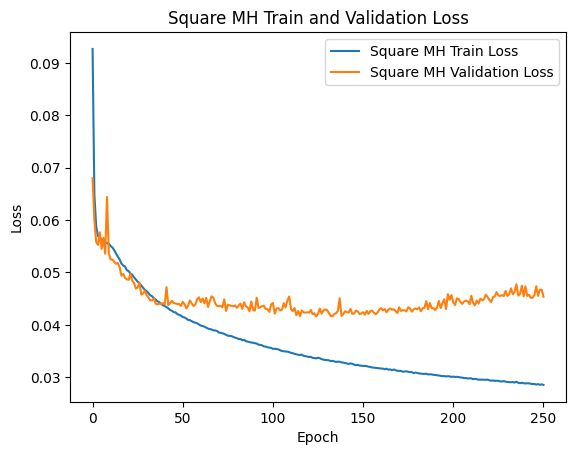

In [ ]:
# SQUARE PH LOSSES ALREADY PLOTTED ABOVE, TO SAVE TRAINING TIME, ONLY PLOTTING SQUARE MH and SQUARE MH MOD LOSSES HERE
# 1) Plot MH Losses
import numpy as np
import matplotlib.pyplot as plt

train_losses = np.array(square_mh_model.train_losses)
valid_losses = np.array(square_mh_model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Square MH Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Square MH Validation Loss")

plt.title("Square MH Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


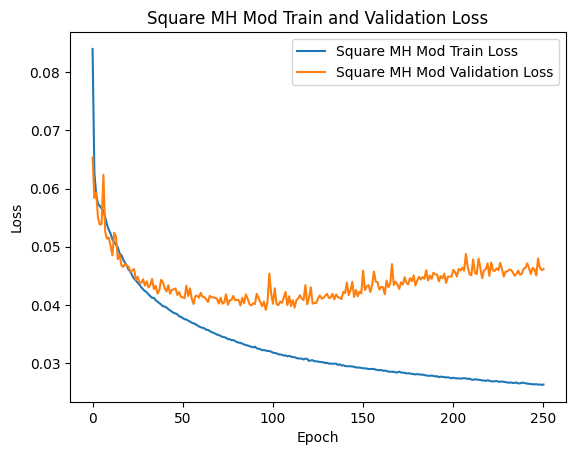

In [ ]:
# SQUARE PH LOSSES ALREADY PLOTTED ABOVE, TO SAVE TRAINING TIME, ONLY PLOTTING SQUARE MH and SQUARE MH MOD LOSSES HERE
# 1) Plot MH Losses
import numpy as np
import matplotlib.pyplot as plt

train_losses = np.array(square_mh_model_mod.train_losses)
valid_losses = np.array(square_mh_model_mod.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Square MH Mod Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Square MH Mod Validation Loss")

plt.title("Square MH Mod Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

**Include figures, brief explanation of the figures. You may use more than one cell**

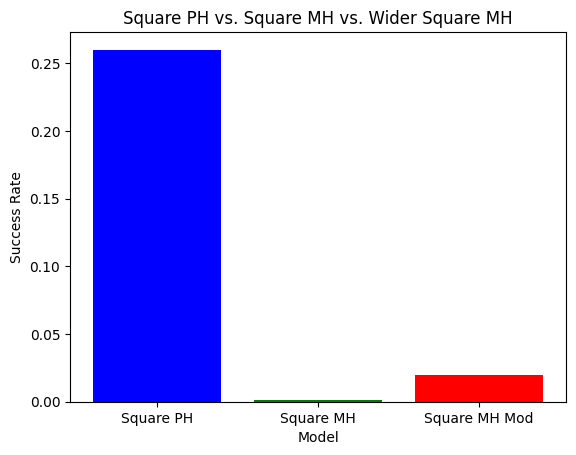

In [ ]:
# Bar graph comparing PH and MH task success rates
import matplotlib.pyplot as plt

# Sample data
categories = ['Square PH', 'Square MH', 'Square MH Mod']
values = [0.26, 0.001, 0.02]

# Create a bar graph
plt.bar(categories, values, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Success Rate')
plt.title('Square PH vs. Square MH vs. Wider Square MH')

# Show the plot
plt.show()


**Enter your analysis here** (be concrete about how each result validates or invalidates your hypothesis and why):

**As shown by the bar chart above, my hypothesis of improving the mh dataset by widening the hidden dimensions was also disproven. The performance was way worse than the ph and only marginally better than the baseline model which I couldn't get any successful rollouts after 2 training and rollout attempts (0%). Future work includes improving both models for a better comparison**

## **Sequence Length/Prediction Horizon (10 PT)**



Example hypothesis: If I increase the sequence length for the RNN, I will see improved task performance on hard tasks.  Additionally, increasing the sequence length will have no affect on the performance of easy tasks.

This is more of a data loader characteristic than a dataset characteristic. But we want to make sure that you also experiment with the prediction horizons and sequence lenghts of the models.  If you choose to do this for RNN, you will just be changing with the sequence length that you pass into the data loader.  If you choose to do this for the diffusion model you should experiment with the predicion horizon and the action horizon (make sure to read the diffusion policy paper if you are unsure what this means).  You could also do this for the MLP, but you would have to change the input and output dims.

In [14]:
# 3) Load in the tool_hang data (hard) for training
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 1
batch_size = 100
train_loader, valid_loader = load_data_for_training(
    dataset_path=tool_hang_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# Input to the network is observations
# we care about end effector observations
end_effector_pos_dim = 3
end_effector_quat_dim = 4
gripper_qpos_dim = 2
# and object observations
object_dim = 14

# Tool hang has input of 53
input_dim = 53

# Output of the network is actions (7 dimensions for 6 robot joints + 1 gripper)
output_dim = 7

SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 237.81it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 86336/86336 [00:04<00:00, 17890.78it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 210.61it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 9626/9626 [00:00<00:00, 20046.83it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([100, 1, 44])
robot0_eef_pos shape: torch.Size([100, 1, 3])
robot0_eef_quat shape: torch.Size([100, 1, 4])
robot0_gripper_qpos shape: torch.Size([100, 1, 2])
action shape: torch.Size([100, 1, 7])


### TODO:

**Enter your hypotheses here:** If I increase the batch size and sequence length of the LSTM, I will see increased performance on the tool hang (hard) task


**You can add however many code blocks here, but leave the most essential ones upon submission to prove your work.**


**Enter your experiment here:**

1) Train baseline TH RNN model

2) Train a modified TH RNN model (seq_len = 20, batch_size = 200)

3) Compare Success Rates

In [15]:
# input_dim = 23 (observation dims) and output_dim = 7 (actions= dim) are calculated in the first section
# remember, input_dim = end_effector_pos_dim + end_effector_quat_dim + gripper_qpos_dim + object_dim

# you can modify these parameters if you want, but tuning shouldn't be necessary
hidden_dim = 400
num_layers = 2
# make sure rnn_horizon is same as dataloader sequence length
rnn_horizon = 10
tool_hang_SL_model = DLM_RNN(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim, obs_keys = obs_keys, rnn_horizon = rnn_horizon)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tool_hang_SL_model = tool_hang_SL_model.to(device)


In [16]:
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path = os.path.join(path_to_dlm, "trainings/tool_hang_SL")
if not os.path.exists(save_path):
  os.makedirs(save_path)

In [19]:
# 3) Train Baseline Tool Hang RNN
num_epochs = 501

tool_hang_SL_model.train_losses, tool_hang_SL_model.valid_losses = train(
                                  tool_hang_SL_model,
                                  train_loader,
                                  valid_loader,
                                  num_epochs=num_epochs,
                                  save_path=save_path
                                )


Epoch: 0 Train Loss: 0.10851960714596014 Valid Loss: 0.07396125125209081
0 0
Epoch: 10 Train Loss: 0.038589513755006785 Valid Loss: 0.038487868671564715
Epoch: 20 Train Loss: 0.035022156429477036 Valid Loss: 0.03511489898964916
Epoch: 30 Train Loss: 0.032792791625036406 Valid Loss: 0.0342978672652515
Epoch: 40 Train Loss: 0.03136881139922749 Valid Loss: 0.03230772057989823
Epoch: 50 Train Loss: 0.03027625887275294 Valid Loss: 0.03151885133966343
50 50
Epoch: 60 Train Loss: 0.029330360578131622 Valid Loss: 0.03075420212231039
Epoch: 70 Train Loss: 0.028496293499807104 Valid Loss: 0.02930151723018012
Epoch: 80 Train Loss: 0.02747537343573101 Valid Loss: 0.028234884814964126
Epoch: 90 Train Loss: 0.026479442768807832 Valid Loss: 0.027649259204332977
Epoch: 100 Train Loss: 0.02559556425721557 Valid Loss: 0.028457557724923203
100 100
Epoch: 110 Train Loss: 0.02483345846714521 Valid Loss: 0.026310228992291948
Epoch: 120 Train Loss: 0.02430609222803334 Valid Loss: 0.026029268126051452
Epoch: 

In [17]:
# 4) Load saved model if you have checkpoints from previous training runs
tool_hang_SL_model.load(os.path.join(save_path, "epoch_500.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_450.pth"))

In [18]:
# 5) Make Modified Tool Hang
from helper import load_data_for_training
obs_keys = ["object", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
seq_len = 20
batch_size = 200
train_loader, valid_loader = load_data_for_training(
    dataset_path=tool_hang_path,
    obs_keys=obs_keys,
    seq_len=seq_len,
    batch_size=batch_size
)

# you can modify these parameters if you want, but tuning shouldn't be necessary
hidden_dim = 400
num_layers = 2
# make sure rnn_horizon is same as dataloader sequence length
rnn_horizon = 20
tool_hang_SL_model_mod = DLM_RNN(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim, obs_keys = obs_keys, rnn_horizon = rnn_horizon)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tool_hang_SL_model_mod = tool_hang_SL_model_mod.to(device)


SequenceDataset: loading dataset into memory...
100%|██████████| 180/180 [00:00<00:00, 236.45it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 86336/86336 [00:08<00:00, 10404.62it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 20/20 [00:00<00:00, 239.11it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 9626/9626 [00:00<00:00, 16127.85it/s]
batch keys: dict_keys(['actions', 'obs'])
observation shapes: 
object shape: torch.Size([200, 20, 44])
robot0_eef_pos shape: torch.Size([200, 20, 3])
robot0_eef_quat shape: torch.Size([200, 20, 4])
robot0_gripper_qpos shape: torch.Size([200, 20, 2])
action shape: torch.Size([200, 20, 7])


In [19]:
from helper import train

# model epochs saved to save_path/epoch_x.pth where x is every 50 epochs
save_path_mod = os.path.join(path_to_dlm, "trainings/tool_hang_SL_mod")
if not os.path.exists(save_path_mod):
  os.makedirs(save_path_mod)

In [22]:
# 3) Train Baseline Tool Hang RNN
num_epochs = 501

tool_hang_SL_model_mod.train_losses, tool_hang_SL_model_mod.valid_losses = train(
                                  tool_hang_SL_model_mod,
                                  train_loader,
                                  valid_loader,
                                  num_epochs=num_epochs,
                                  save_path=save_path_mod
                                )


Epoch: 0 Train Loss: 0.09983010254627853 Valid Loss: 0.06722692134124893
0 0
Epoch: 10 Train Loss: 0.029173068245182985 Valid Loss: 0.030428745954924702
Epoch: 20 Train Loss: 0.024284468321302148 Valid Loss: 0.02838078103199297
Epoch: 30 Train Loss: 0.021663559294581688 Valid Loss: 0.025075195661308815
Epoch: 40 Train Loss: 0.019222916453145444 Valid Loss: 0.024387302979522824
Epoch: 50 Train Loss: 0.017325669887078995 Valid Loss: 0.02444524880574674
50 50
Epoch: 60 Train Loss: 0.01573514728806913 Valid Loss: 0.024693794662551005
Epoch: 70 Train Loss: 0.014141329387375326 Valid Loss: 0.025553911050059358
Epoch: 80 Train Loss: 0.013054979855142947 Valid Loss: 0.02637086694641989
Epoch: 90 Train Loss: 0.011958572125338294 Valid Loss: 0.025461363587148334
Epoch: 100 Train Loss: 0.011229833221511432 Valid Loss: 0.026260267334933182
100 100
Epoch: 110 Train Loss: 0.010553658782521746 Valid Loss: 0.02527757840497153
Epoch: 120 Train Loss: 0.009987463965511846 Valid Loss: 0.025617217721075426

In [20]:
# 4) Load saved model if you have checkpoints from previous training runs
tool_hang_SL_model_mod.load(os.path.join(save_path_mod, "epoch_500.pth"), map_location=torch.device('cpu'))
#model.load(os.path.join(save_path, "epoch_450.pth"))

In [21]:
# TH Original Rollouts
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(tool_hang_SL_model,
                      tool_hang_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))


[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /content/./robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name ToolHang
Action size is 7
Success rate over 50 rollouts: 0.0


In [22]:
#TH Mod Rollouts
from helper import rollout
import imageio

num_rollouts = 50
success_rate = rollout(tool_hang_SL_model_mod,
                      tool_hang_path,
                      horizon = 400,
                      video_writer = None,
                      obs_keys = obs_keys,
                      num_rollouts = num_rollouts)
print("Success rate over {} rollouts: {}".format(num_rollouts, success_rate))

Created environment with name ToolHang
Action size is 7
Success rate over 50 rollouts: 0.0


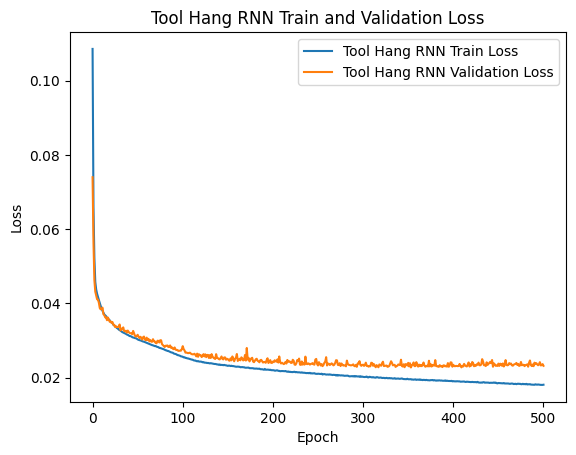

In [23]:
# 1) Plot Tool Hang Original Losses
import numpy as np
import matplotlib.pyplot as plt

train_losses = np.array(tool_hang_SL_model.train_losses)
valid_losses = np.array(tool_hang_SL_model.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Tool Hang RNN Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Tool Hang RNN Validation Loss")

plt.title("Tool Hang RNN Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


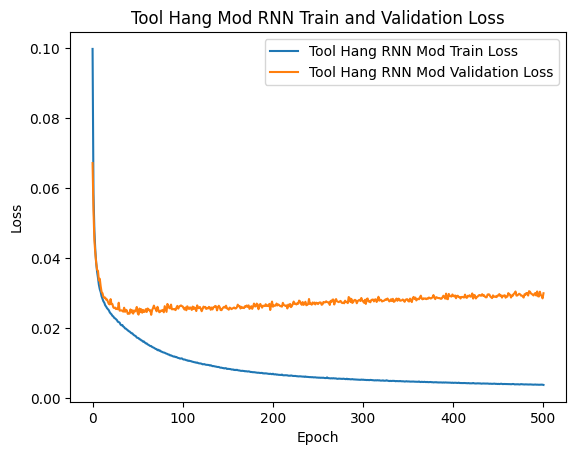

In [24]:
# 1) Plot Tool Hang Mod Losses
import numpy as np
import matplotlib.pyplot as plt

train_losses = np.array(tool_hang_SL_model_mod.train_losses)
valid_losses = np.array(tool_hang_SL_model_mod.valid_losses)

# plot
# train_losses and validation_losses are in column 1, epochs are in column 0
plt.plot(train_losses[:, 1], train_losses[:, 0], label="Tool Hang RNN Mod Train Loss")
plt.plot(valid_losses[:, 1], valid_losses[:, 0], label="Tool Hang RNN Mod Validation Loss")

plt.title("Tool Hang Mod RNN Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()


**Include figures, brief explanation of the figures. You may use more than one cell**

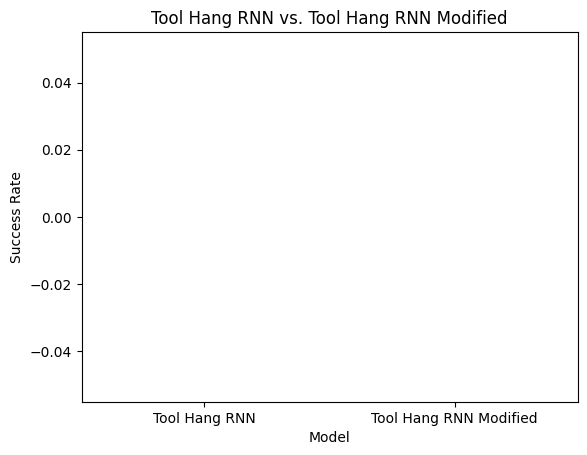

In [24]:
# Bar graph comparing Tool Hang RNN and Tool Hang Mod RNN task success rates
import matplotlib.pyplot as plt

# Sample data
categories = ['Tool Hang RNN', 'Tool Hang RNN Modified']
values = [0, 0]

# Create a bar graph
plt.bar(categories, values, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Success Rate')
plt.title('Tool Hang RNN vs. Tool Hang RNN Modified')


# Show the plot
plt.show()


**Enter your analysis here** (be concrete about how each result validates or invalidates your hypothesis and why):

As shown by the bar graph above (or absence thereof), my hypothesis of increasing seq_length and batch_size for the RNN did not improve TH performance at all. I wanted to test this hypothesis to see if I can get any positive rollouts for the TH and I was unsuccessful.

 -----------------

## TODO - Submit to Gradescope
This is the end of the assignment

**Please download this notebook as a PDF and submit to gradescope**

Make sure you have not deleted any cell outputs that have final answers/success rates

------

Written by Matthew Bronars